In [171]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_selection import VarianceThreshold 
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score

import warnings
warnings.filterwarnings('ignore')

Importing librairies all in one !

In [172]:
numerical = pd.read_csv('files_for_lab/numerical.csv')
categorical = pd.read_csv('files_for_lab/categorical.csv')
targets = pd.read_csv('files_for_lab/target.csv')

In [173]:
numerical

,TCODE,AGE,INCOME,WEALTH1,HIT,MALEMILI,MALEVET,VIETVETS,WWIIVETS,LOCALGOV,...,CARDGIFT,MINRAMNT,MAXRAMNT,LASTGIFT,TIMELAG,AVGGIFT,CONTROLN,HPHONE_D,RFA_2F,CLUSTER2
0,0,60.000000,5,9,0,0,39,34,18,10,...,14,5.0,12.0,10.0,4,7.741935,95515,0,4,39
1,1,46.000000,6,9,16,0,15,55,11,6,...,1,10.0,25.0,25.0,18,15.666667,148535,0,2,1
2,1,61.611649,3,1,2,0,20,29,33,6,...,14,2.0,16.0,5.0,12,7.481481,15078,1,4,60
3,0,70.000000,1,4,2,0,23,14,31,3,...,7,2.0,11.0,10.0,9,6.812500,172556,1,4,41
4,0,78.000000,3,2,60,1,28,9,53,26,...,8,3.0,15.0,15.0,14,6.864865,7112,1,2,26
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95407,1,61.611649,5,9,0,14,36,47,11,7,...,0,25.0,25.0,25.0,9,25.000000,184568,0,1,12
95408,1,48.000000,7,9,1,0,31,43,19,4,...,0,20.0,20.0,20.0,9,20.000000,122706,1,1,2
95409,1,60.000000,5,9,0,0,18,46,20,7,...,4,3.0,10.0,10.0,3,8.285714,189641,1,3,34
95410,0,58.000000,7,9,0,0,28,35,20,9,...,18,5.0,21.0,18.0,4,12.146341,4693,1,4,11


snake case

In [174]:
def fe8 (x:str):
    x = x.replace(" ","_")
    x = x.replace("/", "_")
    return x.lower()

categorical.columns = list(map(fe8, categorical.columns))
numerical.columns = list(map(fe8, numerical.columns))
targets.columns =list(map(fe8, targets.columns))

splitting the data

In [181]:
data = pd.concat([numerical,categorical, targets],axis = 1)
y_b = targets['target_b']
y_d = targets['target_d']
X = data.drop(['target_b', 'target_d'], axis = 1)

Encoding the categoricals

In [182]:
encoder = OneHotEncoder(drop='first').fit(categorical)
encoded_categorical = encoder.transform(categorical).toarray()
encoded_categorical_df = pd.DataFrame(encoded_categorical, columns = encoder.get_feature_names_out())


Scaling numericals

In [184]:
scaler = MinMaxScaler()
numerical_min_scaled = scaler.fit_transform(numerical)
X = pd.concat([numerical, encoded_categorical_df], axis = 1)

splitting the data

In [185]:
X_train, X_test, y_b_train, y_b_test = train_test_split(X, y_b, test_size = 0.2, random_state =88)

building 2 models without oversampling the data , nor features selections

First let's tune the hyperparameters to see what we will use on this particular dataset

In [186]:
from sklearn.model_selection import cross_validate



Pipeline with 2 models to assert witch is the best classifeir for our data

In [187]:
logreg = LogisticRegression(random_state = 88, solver='lbfgs')
logreg.fit(X_train, y_b_train)
pred_log = logreg.predict(X_test)

deci_tree = DecisionTreeClassifier(max_depth = 5,  
                                min_samples_split = 20,  
                                min_samples_leaf = 20,
                                random_state = 88)

deci_tree.fit(X_train, y_b_train)
pred_rand = deci_tree.predict(X_test)

In [467]:
model_pipeline = [LogisticRegression(), DecisionTreeClassifier(), RandomForestClassifier()]
model_names = ['Logistic regression', 'Decision tree', 'randomforest']
scores_pipe_classif= {}
for model, model_name in zip(model_pipeline, model_names):
    mean_score = np.mean(cross_val_score(model, X_train, y_b_train, cv = 10))
    scores_pipe_classif[model_name] = mean_score
print(scores_pipe_classif)

{'Logistic regression': 0.9493508254459494, 'Decision tree': 0.8941555716640288, 'randomforest': 0.9500714015277918}


because of the imbalance Data we can not use those algorithms 

## Features selections

Variance threshold selection

In [191]:
var_threshold = 0.03
sel = VarianceThreshold(threshold = (var_threshold))
selector = sel.fit_transform(X)

tempo = pd.DataFrame(selector)
sel.variances_ > var_threshold   # witch col are greater than the threshold value
sel.get_support()
var_list = list(sel.get_support())
list(zip(X.columns, var_list))

[('tcode', True),
 ('age', True),
 ('income', True),
 ('wealth1', True),
 ('hit', True),
 ('malemili', True),
 ('malevet', True),
 ('vietvets', True),
 ('wwiivets', True),
 ('localgov', True),
 ('stategov', True),
 ('fedgov', True),
 ('wealth2', True),
 ('pop901', True),
 ('pop902', True),
 ('pop903', True),
 ('pop90c1', True),
 ('pop90c2', True),
 ('pop90c3', True),
 ('pop90c4', True),
 ('pop90c5', True),
 ('eth1', True),
 ('eth2', True),
 ('eth3', True),
 ('eth4', True),
 ('eth5', True),
 ('eth6', True),
 ('eth7', True),
 ('eth8', True),
 ('eth9', True),
 ('eth10', True),
 ('eth11', True),
 ('eth12', True),
 ('eth13', True),
 ('eth14', True),
 ('eth15', True),
 ('eth16', True),
 ('age901', True),
 ('age902', True),
 ('age903', True),
 ('age904', True),
 ('age905', True),
 ('age906', True),
 ('age907', True),
 ('chil1', True),
 ('chil2', True),
 ('chil3', True),
 ('agec1', True),
 ('agec2', True),
 ('agec3', True),
 ('agec4', True),
 ('agec5', True),
 ('agec6', True),
 ('agec7', True)

In [192]:
list_to_drop = [col[0] for col in zip(X.columns, var_list) if col[1] == False]  # list of colum to drop
list_to_keep = [col[0] for col in zip(X.columns, var_list) if col[1] == True]

In [193]:
removed_columns = pd.DataFrame(data=(X.columns,sel.variances_,sel.get_support()), index=('column_name','variance','statement')).T
removed_columns.loc[(removed_columns['statement'] == False),:] 

,column_name,variance,statement
320,state_MO,0.027616,False
324,state_WI,0.028436,False
326,cluster_2,0.01994,False
327,cluster_3,0.014743,False
328,cluster_4,0.005845,False
...,...,...,...
609,firstdate_yr_83,0.000157,False
610,firstdate_yr_84,0.000241,False
611,firstdate_yr_85,0.00043,False
626,firstdate_mm_5,0.018681,False


removing 208 columns

In [221]:

X_slice = X.drop(list_to_drop, axis = 1)
X_sclice_scaled = scaler.fit_transform(X)

In [250]:
X_slice

,tcode,age,income,wealth1,hit,malemili,malevet,vietvets,wwiivets,localgov,stategov,fedgov,wealth2,pop901,pop902,pop903,pop90c1,pop90c2,pop90c3,pop90c4,pop90c5,eth1,eth2,eth3,eth4,eth5,eth6,eth7,eth8,eth9,eth10,eth11,eth12,eth13,eth14,eth15,eth16,age901,age902,age903,age904,age905,age906,age907,chil1,chil2,chil3,agec1,agec2,agec3,agec4,agec5,agec6,agec7,chilc1,chilc2,chilc3,chilc4,chilc5,hhage1,hhage2,hhage3,hhn1,hhn2,hhn3,hhn4,hhn5,hhn6,marr1,marr2,marr3,marr4,hhp1,hhp2,dw1,dw2,dw3,dw4,dw5,dw6,dw7,dw8,dw9,hv1,hv2,hv3,hv4,hu1,hu2,hu3,hu4,hu5,hhd1,hhd2,hhd3,hhd4,hhd5,hhd6,hhd7,hhd8,hhd9,hhd10,hhd11,hhd12,ethc1,ethc2,ethc3,ethc4,ethc5,ethc6,hvp1,hvp2,hvp3,hvp4,hvp5,hvp6,hur1,hur2,rhp1,rhp2,rhp3,rhp4,hupa1,hupa2,hupa3,hupa4,hupa5,hupa6,hupa7,rp1,rp2,rp3,rp4,msa,adi,dma,ic1,ic2,ic3,ic4,ic5,ic6,ic7,ic8,ic9,ic10,ic11,ic12,ic13,ic14,ic15,ic16,ic17,ic18,ic19,ic20,ic21,ic22,ic23,hhas1,hhas2,hhas3,hhas4,mc1,mc2,mc3,tpe1,tpe2,tpe3,tpe4,tpe5,tpe6,tpe7,tpe8,tpe9,pec1,pec2,tpe10,tpe11,tpe12,tpe13,lfc1,lfc2,lfc3,lfc4,lfc5,lfc6,lfc7,lfc8,lfc9,lfc10,occ1,occ2,occ3,occ4,occ5,occ6,occ7,occ8,occ9,occ10,occ11,occ12,occ13,eic1,eic2,eic3,eic4,eic5,eic6,eic7,eic8,eic9,eic10,eic11,eic12,eic13,eic14,eic15,eic16,oedc1,oedc2,oedc3,oedc4,oedc5,oedc6,oedc7,ec1,ec2,ec3,ec4,ec5,ec6,ec7,ec8,sec1,sec2,sec3,sec4,sec5,afc1,afc2,afc3,afc4,afc5,afc6,vc1,vc2,vc3,vc4,anc1,anc2,anc3,anc4,anc5,anc6,anc7,anc8,anc9,anc10,anc11,anc12,anc13,anc14,anc15,pobc1,pobc2,lsc1,lsc2,lsc3,lsc4,voc1,voc2,voc3,hc1,hc2,hc3,hc4,hc5,hc6,hc7,hc8,hc9,hc10,hc11,hc12,hc13,hc14,hc15,hc16,hc17,hc18,hc19,hc20,hc21,mhuc1,mhuc2,ac1,ac2,cardprom,numprom,cardpm12,numprm12,ramntall,ngiftall,cardgift,minramnt,maxramnt,lastgift,timelag,avggift,controln,hphone_d,rfa_2f,cluster2,state_FL,state_GA,state_IL,state_IN,state_MI,state_NC,state_TX,state_WA,state_other,cluster_12,cluster_24,cluster_27,cluster_35,cluster_36,cluster_40,cluster_49,homeownr_U,gender_M,datasrce_2,datasrce_3,rfa_2a_E,rfa_2a_F,rfa_2a_G,geocode2_B,geocode2_C,geocode2_D,domain_a_R,domain_a_S,domain_a_T,domain_a_U,domain_b_2,domain_b_3,odatew_yr_86,odatew_yr_87,odatew_yr_88,odatew_yr_89,odatew_yr_90,odatew_yr_91,odatew_yr_92,odatew_yr_93,odatew_yr_94,odatew_yr_95,odatew_yr_96,dob_mm_2,minrdate_yr_87,minrdate_yr_88,minrdate_yr_89,minrdate_yr_90,minrdate_yr_91,minrdate_yr_92,minrdate_yr_93,minrdate_yr_94,minrdate_yr_95,minrdate_yr_96,minrdate_mm_2,minrdate_mm_3,minrdate_mm_4,minrdate_mm_5,minrdate_mm_6,minrdate_mm_7,minrdate_mm_9,minrdate_mm_10,minrdate_mm_11,minrdate_mm_12,maxrdate_yr_92,maxrdate_yr_93,maxrdate_yr_94,maxrdate_yr_95,maxrdate_yr_96,maxrdate_mm_2,maxrdate_mm_3,maxrdate_mm_4,maxrdate_mm_5,maxrdate_mm_6,maxrdate_mm_7,maxrdate_mm_8,maxrdate_mm_9,maxrdate_mm_10,maxrdate_mm_11,maxrdate_mm_12,lastdate_yr_96,lastdate_mm_2,lastdate_mm_3,lastdate_mm_4,lastdate_mm_6,lastdate_mm_7,lastdate_mm_8,lastdate_mm_9,lastdate_mm_10,lastdate_mm_11,lastdate_mm_12,firstdate_yr_86,firstdate_yr_87,firstdate_yr_88,firstdate_yr_89,firstdate_yr_90,firstdate_yr_91,firstdate_yr_92,firstdate_yr_93,firstdate_yr_94,firstdate_yr_95,firstdate_yr_96,firstdate_mm_2,firstdate_mm_3,firstdate_mm_4,firstdate_mm_6,firstdate_mm_8,firstdate_mm_9,firstdate_mm_10,firstdate_mm_11,firstdate_mm_12
0,0,60.000000,5,9,0,0,39,34,18,10,2,1,5,992,264,332,0,35,65,47,53,92,1,0,0,11,0,0,0,0,0,0,0,11,0,0,0,39,48,51,40,50,54,25,31,42,27,11,14,18,17,13,11,15,12,11,34,25,18,26,10,23,18,33,49,28,12,4,61,7,12,19,198,276,97,95,2,2,0,0,7,7,0,479,635,3,2,86,14,96,4,7,38,80,70,32,84,16,6,2,5,9,15,3,17,50,25,0,0,0,2,7,13,27,47,0,1,61,58,61,15,4,2,0,0,14,1,0,0,2,5,17,73,0.0,177.0,682.0,307,318,349,378,12883,13,23,23,23,15,1,0,0,1,4,25,24,26,17,2,0,0,2,28,4,51,1,46,54,3,88,8,0,0,0,0,0,0,4,1,13,14,16,2,45,56,64,50,64,44,62,53,99,0,0,9,3,8,13,9,0,3,9,3,15,19,5,4,3,0,3,41,1,0,7,13,6,5,0,4,9,4,1,3,10,2,1,7,78,2,0,120,16,10,39,21,8,4,3,5,20,3,19,4,0,0,0,18,39,0,34,23,18,16,1,4,0,23,0,0,5,1,0,0,0,0,0,2,0,3,74,88,8,0,4,96,77,19,13,31,5,14,14,31,54,46,0,0,90,0,10,0,0,0,33,65,40,99,99,6,2,10,7,27,74,6,1

### Select KBest

In [195]:

kbest = SelectKBest(chi2, k = 30).fit_transform(X_sclice_scaled, y_b)
# Here we choose 30 so that is easier to analyze results later, as we will see
selected = pd.DataFrame(kbest)
model = SelectKBest(chi2, k = 30).fit(X_sclice_scaled, y_b)
df_kbest = pd.DataFrame(data = model.scores_, columns = ['score'])
df_kbest['Column'] = X.columns
# display(df_kbest.sort_values(by = ['score'], ascending = False))

In [196]:
cols = df_kbest.sort_values(by = ['score'], ascending = False).head(30)['Column']
col_list = list(cols)

In [217]:
len(list(cols))

30

### Select RFE (Recursive Feature Elimination)

In [211]:
from sklearn.feature_selection import RFE
from sklearn import linear_model
lm = linear_model.LinearRegression()
rfe = RFE(lm, n_features_to_select=30, verbose=False)
rfe.fit(X_sclice_scaled, y_b)

RFE(estimator=LinearRegression(), n_features_to_select=30, verbose=False)

In [225]:
df_rfe = pd.DataFrame(data = rfe.ranking_, columns=['Rank'])
df_rfe['Column_name'] = pd.DataFrame(X).columns
df_rfe[df_rfe['Rank'] < 11]
df_rfe['Rank'].value_counts()
len(df_rfe[df_rfe['Rank'] == 1])
cols_rfe = df_rfe.sort_values(by = ['Rank'], ascending = False).head(30)['Column_name']
cols_rfe_list = list(cols_rfe)
len(cols_rfe_list)
# list(cols_rfe)

30

In [229]:
pd.set_option('display.max_columns', None)

In [230]:
raw_data_sclice_rfe = pd.concat([X[cols_rfe_list], y_b], axis = 1)
raw_data_sclice_rfe

,anc3,gender_M,dob_mm_2,dob_yr_55,vc2,hvp4,gender_other,dob_yr_31,firstdate_mm_12,hupa4,geocode2_B,hhas3,tpe11,dob_yr_40,dob_mm_11,dob_yr_34,firstdate_mm_11,wwiivets,datasrce_3,geocode2_C,msa,lfc10,dob_yr_13,dob_mm_5,cluster2,stategov,minrdate_mm_7,minrdate_mm_11,maxrdate_yr_79,minrdate_mm_8,target_b
0,0,0.0,0.0,0.0,23,27,0.0,0.0,0.0,14,0.0,51,16,0.0,0.0,0.0,1.0,18,1.0,1.0,0.0,0,0.0,0.0,39,2,0.0,0.0,0.0,1.0,0
1,0,1.0,1.0,0.0,10,98,0.0,0.0,0.0,4,0.0,66,32,0.0,0.0,0.0,0.0,11,1.0,0.0,4480.0,0,0.0,0.0,1,2,0.0,0.0,0.0,0.0,0
2,1,1.0,1.0,0.0,23,18,0.0,0.0,0.0,11,0.0,31,24,0.0,0.0,0.0,0.0,33,1.0,1.0,0.0,4,0.0,0.0,60,8,0.0,1.0,0.0,0.0,0
3,0,0.0,0.0,0.0,40,69,0.0,0.0,0.0,42,0.0,26,15,0.0,0.0,0.0,0.0,31,1.0,1.0,9340.0,23,0.0,0.0,41,0,0.0,1.0,0.0,0.0,0
4,0,0.0,0.0,0.0,16,16,0.0,0.0,0.0,9,0.0,11,27,0.0,0.0,0.0,0.0,53,1.0,0.0,5000.0,10,0.0,0.0,26,3,0.0,0.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95407,1,1.0,1.0,0.0,15,73,0.0,0.0,0.0,14,0.0,70,20,0.0,0.0,0.0,0.0,11,1.0,1.0,380.0,7,0.0,0.0,12,8,0.0,0.0,0.0,0.0,0
95408,1,1.0,0.0,0.0,5,91,0.0,0.0,0.0,7,0.0,61,32,0.0,0.0,0.0,0.0,19,1.0,0.0,3360.0,0,0.0,0.0,2,1,0.0,0.0,0.0,0.0,0
95409,0,1.0,0.0,0.0,0,1,0.0,0.0,0.0,31,1.0,26,17,0.0,0.0,0.0,0.0,20,1.0,0.0,4040.0,25,0.0,0.0,34,23,0.0,0.0,0.0,0.0,0
95410,1,0.0,0.0,0.0,18,99,0.0,0.0,1.0,12,0.0,46,28,1.0,0.0,0.0,0.0,20,0.0,0.0,8735.0,0,0.0,1.0,11,1,0.0,1.0,0.0,0.0,1


In [231]:
raw_data_sclice = pd.concat([X[cols], y_b], axis = 1)
raw_data_sclice

,rfa_2f,rfa_2a_G,rfa_2a_E,odatew_yr_96,lastdate_yr_97,lastdate_yr_96,rfa_2a_F,odatew_yr_97,firstdate_yr_96,lastdate_mm_4,odatew_mm_11,odatew_yr_86,minrdate_mm_5,cardgift,hvp1,hvp2,firstdate_yr_86,firstdate_yr_95,odatew_mm_4,hvp3,lastdate_mm_2,hvp6,dob_yr_83,odatew_mm_8,firstdate_mm_8,domain_b_3,maxrdate_yr_95,firstdate_yr_88,maxrdate_yr_93,hvp4,target_b
0,4,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14,2,7,0.0,0.0,0.0,13,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,27,0
1,2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,97,98,0.0,0.0,0.0,98,0.0,94,0.0,0.0,0.0,0.0,1.0,0.0,0.0,98,0
2,4,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14,0,1,0.0,0.0,0.0,6,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,18,0
3,4,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7,10,25,0.0,0.0,0.0,50,0.0,10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,69,0
4,2,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,8,0,1,0.0,0.0,0.0,2,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,16,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95407,1,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0,2,10,0.0,0.0,0.0,49,1.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,73,0
95408,1,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0,18,71,0.0,0.0,0.0,88,0.0,5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,91,0
95409,3,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4,0,0,0.0,0.0,0.0,0,0.0,0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1,0
95410,4,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,18,89,96,1.0,0.0,0.0,99,0.0,9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,99,1


In [232]:
raw_data_sclice.columns == raw_data_sclice_rfe.columns

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False,  True])

the 2 methods do not coincide with our feature selcetion ...

CONCAT

In [238]:
# raw_data = pd.concat([nums[cols], y_b], axis = 1)
# scaler = MinMaxScaler()
# raw_data_scaled = scaler.fit_transform(raw_data)

# raw_data_sclice = pd.concat([X[cols], y_b], axis = 1)
# scaler_min = MinMaxScaler()
# raw_data__sclice_scaled = scaler_min.fit_transform(raw_data_sclice)



scaler_min = MinMaxScaler()
raw_data__sclice_scaled = scaler_min.fit_transform(raw_data_sclice)
raw_data_sclice_rfe_scaled = scaler_min.fit_transform(raw_data_sclice_rfe)

display(raw_data_sclice, raw_data_sclice_rfe)

,rfa_2f,rfa_2a_G,rfa_2a_E,odatew_yr_96,lastdate_yr_97,lastdate_yr_96,rfa_2a_F,odatew_yr_97,firstdate_yr_96,lastdate_mm_4,odatew_mm_11,odatew_yr_86,minrdate_mm_5,cardgift,hvp1,hvp2,firstdate_yr_86,firstdate_yr_95,odatew_mm_4,hvp3,lastdate_mm_2,hvp6,dob_yr_83,odatew_mm_8,firstdate_mm_8,domain_b_3,maxrdate_yr_95,firstdate_yr_88,maxrdate_yr_93,hvp4,target_b
0,4,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14,2,7,0.0,0.0,0.0,13,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,27,0
1,2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,97,98,0.0,0.0,0.0,98,0.0,94,0.0,0.0,0.0,0.0,1.0,0.0,0.0,98,0
2,4,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14,0,1,0.0,0.0,0.0,6,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,18,0
3,4,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7,10,25,0.0,0.0,0.0,50,0.0,10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,69,0
4,2,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,8,0,1,0.0,0.0,0.0,2,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,16,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95407,1,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0,2,10,0.0,0.0,0.0,49,1.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,73,0
95408,1,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0,18,71,0.0,0.0,0.0,88,0.0,5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,91,0
95409,3,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4,0,0,0.0,0.0,0.0,0,0.0,0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1,0
95410,4,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,18,89,96,1.0,0.0,0.0,99,0.0,9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,99,1


,anc3,gender_M,dob_mm_2,dob_yr_55,vc2,hvp4,gender_other,dob_yr_31,firstdate_mm_12,hupa4,geocode2_B,hhas3,tpe11,dob_yr_40,dob_mm_11,dob_yr_34,firstdate_mm_11,wwiivets,datasrce_3,geocode2_C,msa,lfc10,dob_yr_13,dob_mm_5,cluster2,stategov,minrdate_mm_7,minrdate_mm_11,maxrdate_yr_79,minrdate_mm_8,target_b
0,0,0.0,0.0,0.0,23,27,0.0,0.0,0.0,14,0.0,51,16,0.0,0.0,0.0,1.0,18,1.0,1.0,0.0,0,0.0,0.0,39,2,0.0,0.0,0.0,1.0,0
1,0,1.0,1.0,0.0,10,98,0.0,0.0,0.0,4,0.0,66,32,0.0,0.0,0.0,0.0,11,1.0,0.0,4480.0,0,0.0,0.0,1,2,0.0,0.0,0.0,0.0,0
2,1,1.0,1.0,0.0,23,18,0.0,0.0,0.0,11,0.0,31,24,0.0,0.0,0.0,0.0,33,1.0,1.0,0.0,4,0.0,0.0,60,8,0.0,1.0,0.0,0.0,0
3,0,0.0,0.0,0.0,40,69,0.0,0.0,0.0,42,0.0,26,15,0.0,0.0,0.0,0.0,31,1.0,1.0,9340.0,23,0.0,0.0,41,0,0.0,1.0,0.0,0.0,0
4,0,0.0,0.0,0.0,16,16,0.0,0.0,0.0,9,0.0,11,27,0.0,0.0,0.0,0.0,53,1.0,0.0,5000.0,10,0.0,0.0,26,3,0.0,0.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95407,1,1.0,1.0,0.0,15,73,0.0,0.0,0.0,14,0.0,70,20,0.0,0.0,0.0,0.0,11,1.0,1.0,380.0,7,0.0,0.0,12,8,0.0,0.0,0.0,0.0,0
95408,1,1.0,0.0,0.0,5,91,0.0,0.0,0.0,7,0.0,61,32,0.0,0.0,0.0,0.0,19,1.0,0.0,3360.0,0,0.0,0.0,2,1,0.0,0.0,0.0,0.0,0
95409,0,1.0,0.0,0.0,0,1,0.0,0.0,0.0,31,1.0,26,17,0.0,0.0,0.0,0.0,20,1.0,0.0,4040.0,25,0.0,0.0,34,23,0.0,0.0,0.0,0.0,0
95410,1,0.0,0.0,0.0,18,99,0.0,0.0,1.0,12,0.0,46,28,1.0,0.0,0.0,0.0,20,0.0,0.0,8735.0,0,0.0,1.0,11,1,0.0,1.0,0.0,0.0,1


Heatmap for correlation with the target and multicolinearity

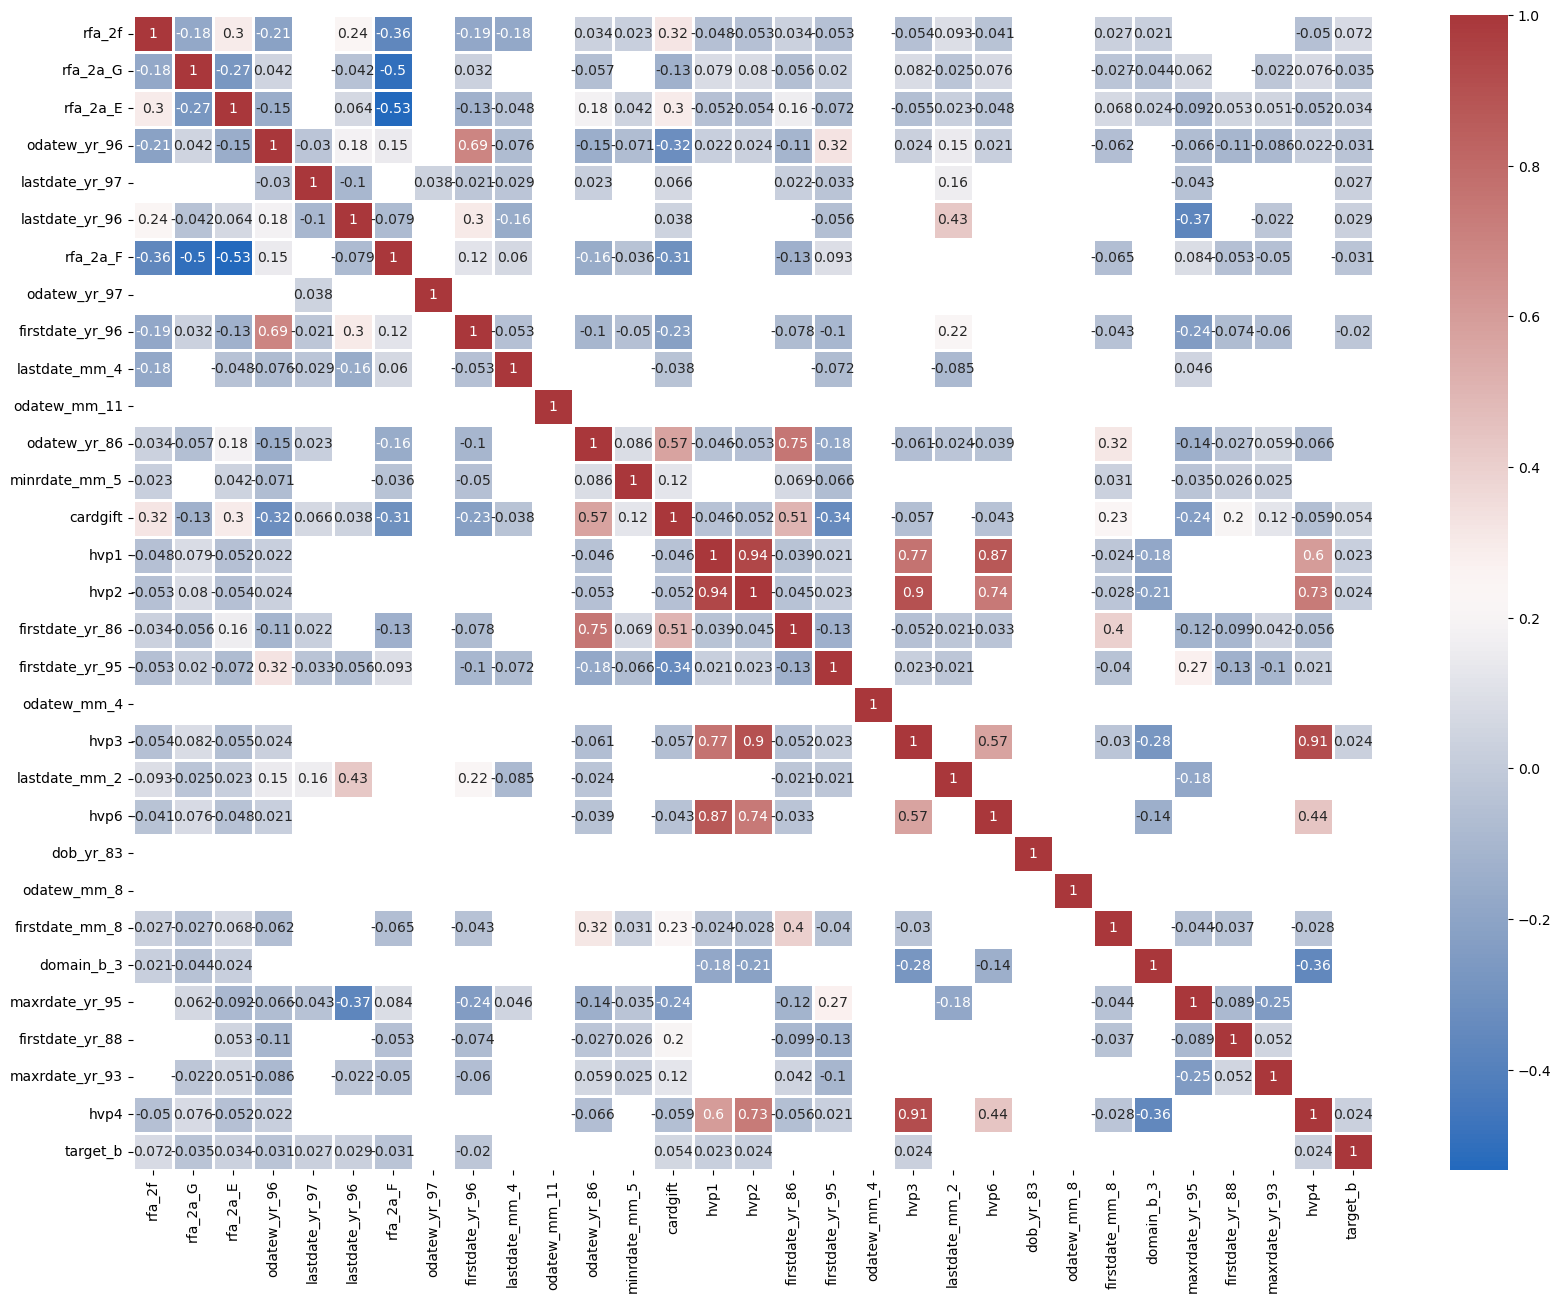

In [495]:
# corr_matrix = raw_data.corr(method= 'pearson')
# fig, ax = plt.subplots(figsize = (20,15))
# ax = sns.heatmap(corr_matrix, annot= True, cmap = sns.color_palette("vlag", as_cmap = True), linewidth = 0.9)
# plt.show()

corr_matrix = raw_data_sclice.corr(method= 'pearson')
fig, ax = plt.subplots(figsize = (20,15))
ax = sns.heatmap(corr_matrix, annot= True, cmap = sns.color_palette("vlag", as_cmap = True), linewidth = 1, mask = (np.abs(corr_matrix) <= 0.02))
plt.show()

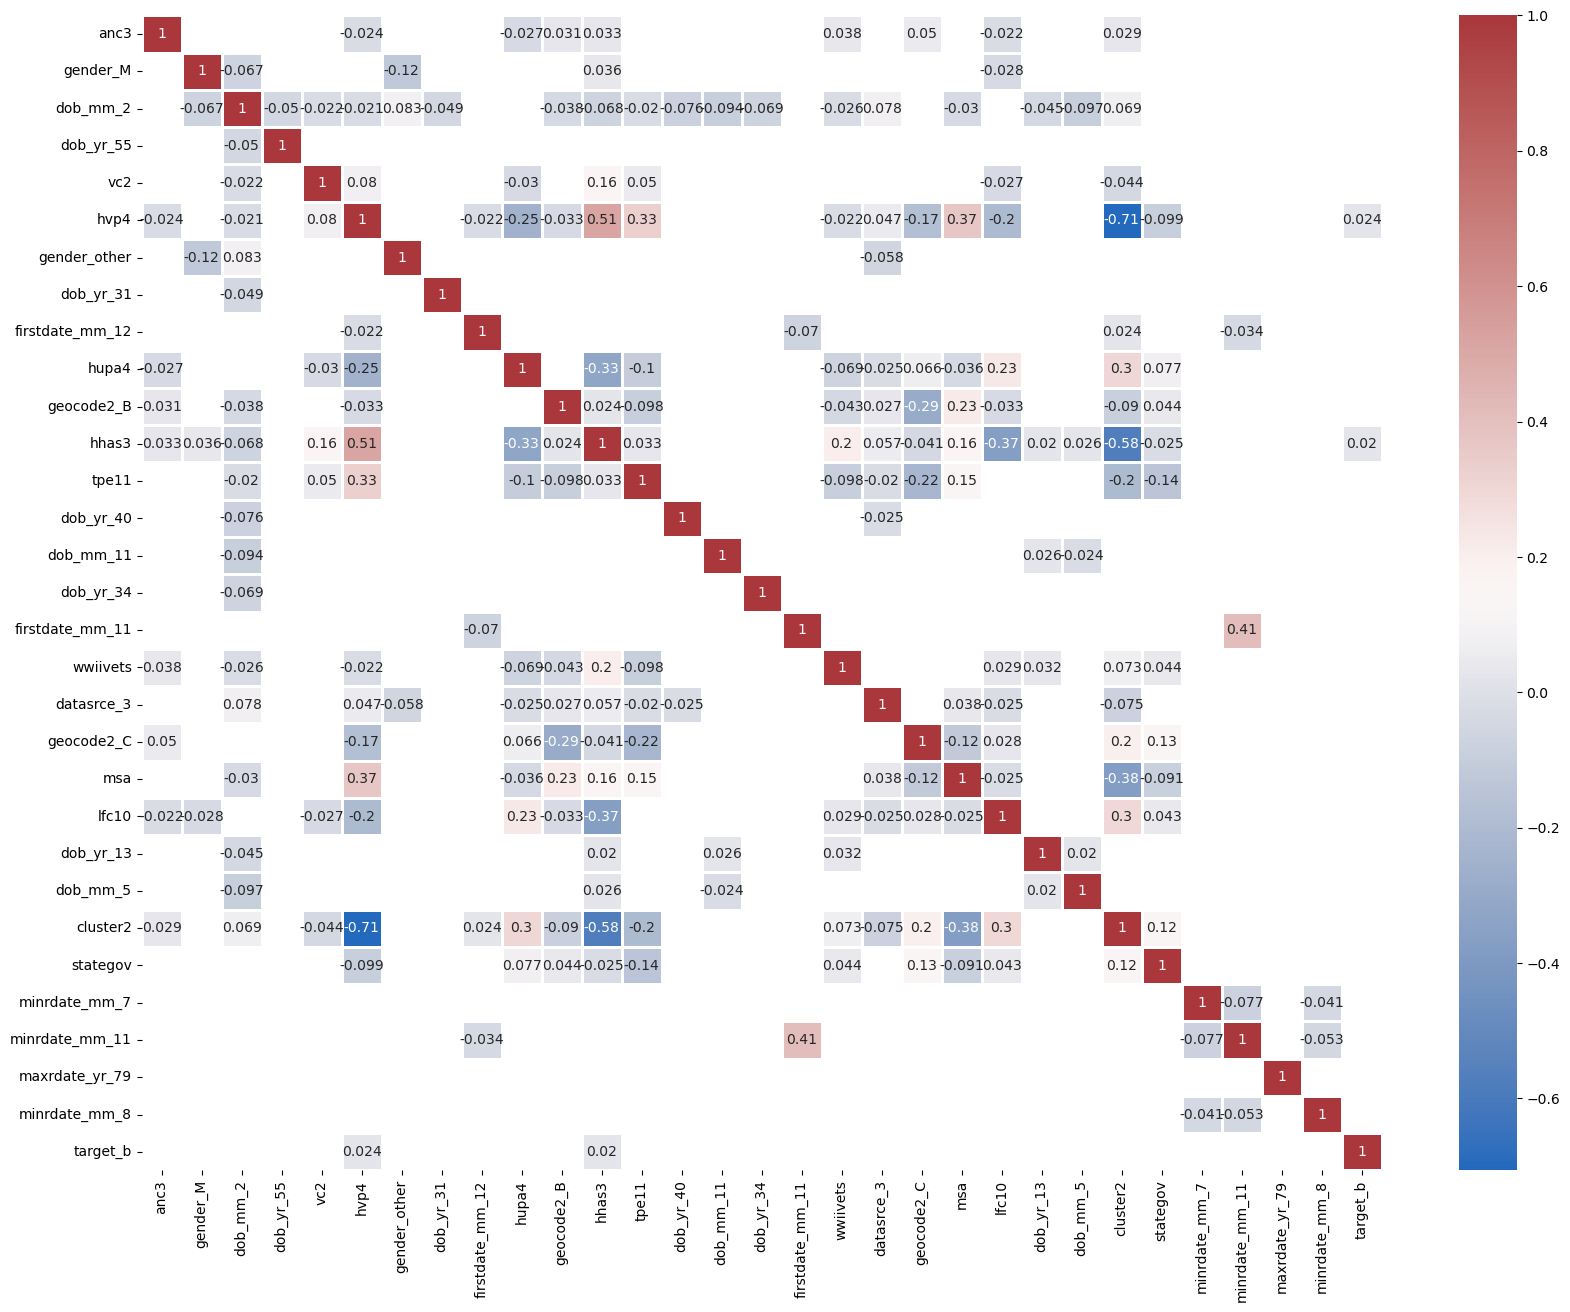

In [494]:
corr_matrix_rfe = raw_data_sclice_rfe.corr(method= 'pearson')
fig, ax = plt.subplots(figsize = (20,15))
ax = sns.heatmap(corr_matrix_rfe, annot= True, cmap = sns.color_palette("vlag", as_cmap = True), linewidth = 1, mask = (np.abs(corr_matrix_rfe) <= 0.02))
plt.show()

Using the healtmap to refine the features to drop (negatives corr are gone !)

We are going to use the Kbest feature selections as there are more features to select from according to the heat map

In [241]:
# data_refined = raw_data.drop(['hvp1', 'hvp2', 'hvp3', 'hvp4', 'hvp5', 'hvp6', 'hv1'], axis =1)

raw_data_sclice_refined = raw_data_sclice.drop([ 'hvp1', 'hvp6', 'rfa_2a_G', 'domain_b_3', 'odatew_yr_96', 'odatew_yr_97', 'rfa_2a_F', 'odatew_mm_11', 'minrdate_mm_5', 'odatew_yr_86', 'firstdate_yr_86', 'maxrdate_yr_93', 'firstdate_yr_95', 'lastdate_mm_4', 'firstdate_yr_96'], axis =1)
raw_data_sclice_refined

,rfa_2f,rfa_2a_E,lastdate_yr_97,lastdate_yr_96,cardgift,hvp2,odatew_mm_4,hvp3,lastdate_mm_2,dob_yr_83,odatew_mm_8,firstdate_mm_8,maxrdate_yr_95,firstdate_yr_88,hvp4,target_b
0,4,1.0,0.0,0.0,14,7,0.0,13,0.0,0.0,0.0,0.0,0.0,0.0,27,0
1,2,0.0,0.0,0.0,1,98,0.0,98,0.0,0.0,0.0,0.0,1.0,0.0,98,0
2,4,1.0,0.0,0.0,14,1,0.0,6,0.0,0.0,0.0,0.0,0.0,0.0,18,0
3,4,1.0,0.0,0.0,7,25,0.0,50,0.0,0.0,0.0,0.0,0.0,0.0,69,0
4,2,0.0,0.0,1.0,8,1,0.0,2,0.0,0.0,0.0,0.0,0.0,0.0,16,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95407,1,0.0,0.0,1.0,0,10,0.0,49,1.0,0.0,0.0,0.0,0.0,0.0,73,0
95408,1,0.0,0.0,1.0,0,71,0.0,88,0.0,0.0,0.0,0.0,0.0,0.0,91,0
95409,3,1.0,0.0,1.0,4,0,0.0,0,0.0,0.0,0.0,0.0,1.0,0.0,1,0
95410,4,0.0,1.0,0.0,18,96,0.0,99,0.0,0.0,0.0,0.0,0.0,0.0,99,1


I will keep Hv2 as it has the highest corr with the target , and removing the others because of multicolinearity

## Imbalance data, oversampling

In [68]:
from sklearn.utils import resample

In [69]:
category_0 = raw_data_sclice_refined[raw_data_sclice_refined['target_b'] == 0]
category_1 = raw_data_sclice_refined[raw_data_sclice_refined['target_b'] == 1]
print(category_0.shape)
print(category_1.shape)

(90569, 20)
(4843, 20)


In [70]:
category_1_oversampled = resample(category_1, 
                                  replace=True, 
                                  n_samples = len(category_0))
category_1_oversampled.shape

(90569, 20)

concat the data with the 2 category, 0 and 1

In [71]:
raw_data_sclice_refined_oversample = pd.concat([category_0, category_1_oversampled], axis = 0)

# taking a fraction of the data the shuffle 
sclice_oversample_fraction = raw_data_sclice_refined_oversample.sample(frac = 0.75)
print(raw_data_sclice_refined_oversample.shape)
sclice_oversample_fraction.shape

(181138, 20)


(135854, 20)

In [72]:
X_over = sclice_oversample_fraction.drop(['target_b'], axis = 1)

y_over = sclice_oversample_fraction['target_b']

X_train_over, X_test_over, y_train_over, y_test_over = train_test_split( X_over, y_over, test_size = 0.2, random_state = 88)

display(X_over.shape)
display(y_over.shape)

(135854, 19)

(135854,)

### Classifier on the oversample

Classification of oversample data with hyperparameters tuned

In [73]:
clf_tuned = RandomForestClassifier(max_depth = 6,  
                             min_samples_split = 5,  
                             min_samples_leaf = 10,
                             n_estimators = 800,
                             max_features = 'sqrt', 
                             bootstrap= False,
                             random_state = 88)

clf_tuned.fit(X_train_over, y_train_over)

print('Score of trainSet = ', clf_tuned.score(X_train_over, y_train_over))
print('Score of testSet = ', clf_tuned.score(X_test_over, y_test_over))

Score of trainSet =  0.5897334449729948
Score of testSet =  0.5875013801479518


Refine the hyperparameters, DO NOT run this in the morning !

In [449]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV


# Number of trees in random forest
# n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
n_estimators = [int(x) for x in range(200, 2000, 100)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt'] 
# Maximum number of levels in tree
# max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
# max_depth.append(None)
max_depth = [3, 4, 5, 6, 7, 8, 9, 10, None]
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10, 20]
# Minimum number of samples required at each leaf node
min_samples_leaf = [2, 4, 10, 20]
# Method of selecting samples for training each tree
bootstrap = [True, False]


random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [102]:

# random_search = RandomizedSearchCV(estimator = RandomForestClassifier(), param_distributions = random_grid, n_iter = 100, cv = 5, n_jobs = -1)
# random_search.fit(X_train, y_b_train)

# grid_search = GridSearchCV(estimator = RandomForestClassifier(), param_grid = random_grid, cv = 10)
# grid_search.fit(X_train, y_b_train)

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [3, 4, 5, 6, 7, 8, 9, 10,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [2, 4, 10, 20],
                                        'min_samples_split': [2, 5, 10, 20],
                                        'n_estimators': [200, 300, 400, 500,
                                                         600, 700, 800, 900,
                                                         1000, 1100, 1200, 1300,
                                                         1400, 1500, 1600, 1700,
                                                         1800, 1900]})

In [103]:
# print(' my hyperparameters are :', random_search.best_params_)
# print ('my average score is : ', random_search.best_score_)

# print(' my best hyperparameters are :' , grid_search.best_params_)
# print ('my average scoe is : ', grid_search.best_score_)

 my hyperparam are : {'n_estimators': 800, 'min_samples_split': 5, 'min_samples_leaf': 10, 'max_features': 'sqrt', 'max_depth': 6, 'bootstrap': False}
my average scoe is :  0.9501631103485568


In [104]:
cross_val_scores = cross_val_score(clf_tuned, X_train_over, y_train_over, cv = 10)
print(cross_val_scores)
print(np.mean(cross_val_scores))


[0.59113074 0.59251081 0.58818659 0.58271991 0.59330144 0.58833272
 0.58732057 0.58502024 0.59431358 0.58382407]
0.5886660670948192


In [105]:
preds_random_forest = clf_tuned.predict(X_test_over)

print('accuracy:', accuracy_score(y_test_over, preds_random_forest))
print("precision: ",precision_score(y_test_over,preds_random_forest))
print("recall: ",recall_score(y_test_over,preds_random_forest))
print("f1: ",f1_score(y_test_over,preds_random_forest))

accuracy: 0.5875013801479518
precision:  0.5900707151709558
recall:  0.5917099203158126
f1:  0.5908891809023216


Predictions and cross validation with the hyperparameters tuned

In [122]:
clf_hyper_tuned = RandomForestClassifier(max_depth = 6,  
                             min_samples_split = 5,  
                             min_samples_leaf = 10,
                             n_estimators = 800,
                             max_features = 'sqrt',
                             bootstrap= False, 
                             random_state = 88)

clf_hyper_tuned.fit(X_train_over, y_train_over)

print('Score of trainSet = ', clf_hyper_tuned.score(X_train_over, y_train_over))
print('Score of testSet = ', clf_hyper_tuned.score(X_test_over, y_test_over))

Score of trainSet =  0.5977843821020766
Score of testSet =  0.5941628942622649


10 cross validations scores

In [123]:
cross_val_scores = cross_val_score(clf_hyper_tuned, X_train_over, y_train_over, cv = 10)
print(cross_val_scores)
print(np.mean(cross_val_scores))

[0.59508694 0.59839912 0.59379888 0.58824071 0.60038646 0.59716599
 0.5937615  0.59228929 0.60149061 0.59228929]
0.5952908788651194


In [124]:
preds_random_forest_tuned = clf_hyper_tuned.predict(X_test_over)

print('accuracy:', accuracy_score(y_test_over, preds_random_forest_tuned))
print("precision: ",precision_score(y_test_over,preds_random_forest_tuned))
print("recall: ",recall_score(y_test_over,preds_random_forest_tuned))
print("f1: ",f1_score(y_test_over,preds_random_forest_tuned))

accuracy: 0.5941628942622649
precision:  0.5993258426966293
recall:  0.5849111777176694
f1:  0.592030781752932


confusion matrix with hyperparameters not tuned 

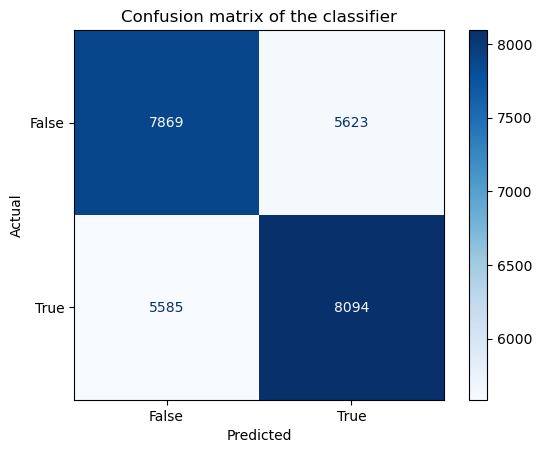

In [490]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn import metrics

confusion_matrix = metrics.confusion_matrix(y_test_over, preds_random_forest)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])
cm_display.plot(cmap = plt.cm.Blues)
plt.title('Confusion matrix of the classifier')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


with hyperparameters tuned 

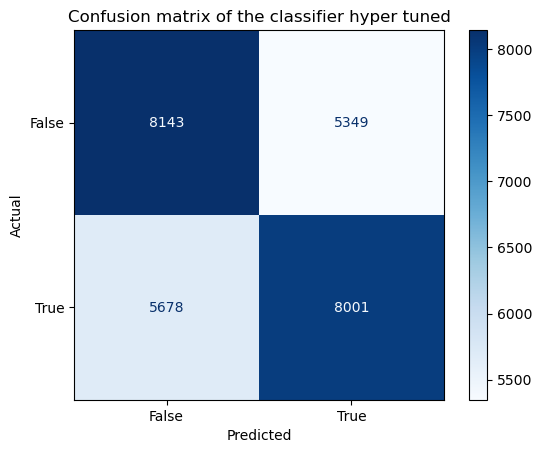

In [487]:
confusion_matrix = metrics.confusion_matrix(y_test_over, preds_random_forest_tuned)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])
cm_display.plot(cmap = plt.cm.Blues)
plt.title('Confusion matrix of the classifier hyper tuned')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


analysing the scores

# Regression on the donors to predict the amount of donations they wil give.


getting the donors from the data set

In [138]:
data

,tcode,age,income,wealth1,hit,malemili,malevet,vietvets,wwiivets,localgov,...,minrdate_yr,minrdate_mm,maxrdate_yr,maxrdate_mm,lastdate_yr,lastdate_mm,firstdate_yr,firstdate_mm,target_b,target_d
0,0,60.000000,5,9,0,0,39,34,18,10,...,92,8,94,2,95,12,89,11,0,0.0
1,1,46.000000,6,9,16,0,15,55,11,6,...,93,10,95,12,95,12,93,10,0,0.0
2,1,61.611649,3,1,2,0,20,29,33,6,...,91,11,92,7,95,12,90,1,0,0.0
3,0,70.000000,1,4,2,0,23,14,31,3,...,87,11,94,11,95,12,87,2,0,0.0
4,0,78.000000,3,2,60,1,28,9,53,26,...,93,10,96,1,96,1,79,3,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95407,1,61.611649,5,9,0,14,36,47,11,7,...,96,2,96,2,96,2,96,2,0,0.0
95408,1,48.000000,7,9,1,0,31,43,19,4,...,96,3,96,3,96,3,96,3,0,0.0
95409,1,60.000000,5,9,0,0,18,46,20,7,...,96,3,95,1,96,10,94,10,0,0.0
95410,0,58.000000,7,9,0,0,28,35,20,9,...,90,11,96,8,97,1,86,12,1,18.0


checking the number of raws of donors

In [107]:
data_donations = data[data['target_b'] == 1]
data_donations

,tcode,age,income,wealth1,hit,malemili,malevet,vietvets,wwiivets,localgov,...,minrdate_yr,minrdate_mm,maxrdate_yr,maxrdate_mm,lastdate_yr,lastdate_mm,firstdate_yr,firstdate_mm,target_b,target_d
20,2,62.000000,3,8,10,2,25,40,27,11,...,88,1,94,4,96,3,87,1,1,4.0
30,0,61.611649,5,9,0,1,37,58,16,8,...,90,4,93,1,95,12,90,4,1,7.0
45,0,66.000000,5,9,5,0,33,24,39,6,...,93,12,94,4,96,2,87,4,1,5.0
78,0,69.000000,6,9,0,0,34,20,54,2,...,90,1,95,3,95,11,90,1,1,13.0
93,1,73.000000,1,7,10,0,21,53,8,5,...,92,9,95,9,95,9,92,9,1,10.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95298,2,45.000000,5,9,0,0,45,28,37,9,...,89,6,96,1,96,1,86,8,1,20.0
95309,0,51.000000,5,6,1,1,32,43,24,7,...,93,10,94,2,95,12,93,10,1,15.0
95398,0,86.000000,5,9,0,1,32,21,26,9,...,89,6,95,11,96,2,87,11,1,3.0
95403,0,58.000000,4,9,0,0,24,46,20,6,...,90,3,93,12,96,1,90,3,1,10.0


#### Variance threshold , and RFE features selections

    - splitting numericals and categoricals

    - scalling numericals and encoding categoricals

    - variance and RFE on numericals and variance on cat

In [244]:
# split
data_donations_num = data_donations.select_dtypes(np.number)
data_donations_cat = data_donations.select_dtypes(object)

In [246]:
# scalled data
encoded_categorical, numerical_min_scaled


(array([[0., 0., 1., ..., 0., 1., 0.],
        [0., 0., 0., ..., 1., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 1., 0., 0.],
        [0., 0., 0., ..., 0., 0., 1.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 array([[0.00000000e+00, 6.08247423e-01, 6.66666667e-01, ...,
         0.00000000e+00, 1.00000000e+00, 6.22950820e-01],
        [1.38885031e-05, 4.63917526e-01, 8.33333333e-01, ...,
         0.00000000e+00, 3.33333333e-01, 0.00000000e+00],
        [1.38885031e-05, 6.24862364e-01, 3.33333333e-01, ...,
         1.00000000e+00, 1.00000000e+00, 9.67213115e-01],
        ...,
        [1.38885031e-05, 6.08247423e-01, 6.66666667e-01, ...,
         1.00000000e+00, 6.66666667e-01, 5.40983607e-01],
        [0.00000000e+00, 5.87628866e-01, 1.00000000e+00, ...,
         1.00000000e+00, 1.00000000e+00, 1.63934426e-01],
        [2.77770062e-05, 8.14432990e-01, 6.66666667e-01, ...,
         1.00000000e+00, 0.00000000e+00, 1.80327869e-01]]))

In [359]:
# variance on numericals
var_threshold_num = 0.02
sel_num = VarianceThreshold(threshold=(var_threshold_num))

sel_num = sel_num.fit(numerical_min_scaled)
temp_num = sel_num.transform(numerical_min_scaled)
temp_num = pd.DataFrame(temp_num)
print(numerical_min_scaled.shape)
print(temp_num.shape)

(95412, 315)
(95412, 79)


In [360]:
sel_num.variances_ > var_threshold_num  
sel_num.get_support()
var_list_num = list(sel_num.get_support())
list(zip(numerical.columns, var_list_num))
list_to_drop_num = [col[0] for col in zip(numerical.columns, var_list_num) if col[1] == False] 

Dropping columns in numerical from variance selection

In [361]:
num = numerical.drop(list_to_drop_num, axis = 1)
num

,age,income,wealth1,vietvets,wwiivets,wealth2,pop90c1,pop90c2,pop90c3,eth1,eth2,hhn3,dw1,dw2,dw4,dw5,dw6,hv1,hv2,hv3,hv4,hu1,hu2,hu5,hhd2,hhd3,hhd5,ethc2,hvp1,hvp2,hvp3,hvp4,hvp5,hvp6,hur2,hupa2,hupa3,hupa6,rp1,rp2,rp3,rp4,msa,adi,ic6,hhas3,mc1,mc2,pec2,tpe13,lfc2,lfc4,lfc6,lfc7,lfc8,lfc9,vc1,vc3,pobc2,lsc1,voc2,hc2,hc4,hc5,hc6,hc7,hc8,hc11,hc13,hc17,hc18,hc19,mhuc1,mhuc2,cardprom,controln,hphone_d,rfa_2f,cluster2
0,60.000000,5,9,34,18,5,0,35,65,92,1,49,97,95,2,0,0,479,635,3,2,86,14,7,80,70,84,50,2,7,13,27,47,0,61,0,0,0,2,5,17,73,0.0,177.0,13,51,46,54,13,45,64,64,62,53,99,0,34,18,74,88,77,31,14,14,31,54,46,90,10,33,65,40,6,2,27,95515,0,4,39
1,46.000000,6,9,55,11,9,99,0,0,67,0,75,99,99,0,0,0,5468,5218,12,10,96,4,9,94,88,95,44,97,98,98,98,99,94,83,0,0,0,91,91,91,94,4480.0,13.0,2,66,56,44,2,71,83,81,64,57,99,99,55,11,39,50,92,10,26,56,97,99,0,96,4,99,0,99,20,4,12,148535,0,2,1
2,61.611649,3,1,29,33,1,0,2,98,96,2,44,69,69,6,5,3,497,546,2,1,78,22,18,76,65,86,60,0,1,6,18,50,0,36,2,24,3,0,2,9,44,0.0,281.0,32,31,38,62,21,61,73,70,78,62,82,99,28,32,84,96,65,22,12,23,50,69,31,0,35,22,77,17,9,2,26,15078,1,4,60
3,70.000000,1,4,14,31,0,0,8,92,61,0,50,85,83,4,1,0,1000,1263,2,1,48,52,6,73,61,84,36,10,25,50,69,92,10,42,0,9,0,1,8,17,34,9340.0,67.0,27,26,46,54,17,43,81,68,33,31,0,99,14,31,67,56,43,38,10,19,39,45,55,45,17,23,77,22,16,2,27,172556,1,4,41
4,78.000000,3,2,9,53,9,99,0,0,2,98,57,99,98,0,0,0,576,594,4,3,90,10,0,82,49,92,1,0,1,2,16,67,0,45,0,0,0,25,58,74,83,5000.0,127.0,24,11,20,80,1,76,73,65,80,31,81,99,9,53,65,99,45,34,1,3,6,33,67,9,72,99,1,21,6,2,43,7112,1,2,26
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95407,61.611649,5,9,47,11,9,99,0,0,78,10,48,54,38,32,24,14,988,1025,6,6,56,44,3,72,56,83,55,2,10,49,73,92,0,40,8,13,12,69,84,92,97,380.0,0.0,11,70,63,37,2,69,89,83,69,57,61,94,48,11,26,92,60,14,7,32,78,91,9,86,12,93,7,98,16,4,6,184568,0,1,12
95408,48.000000,7,9,43,19,9,96,0,4,91,3,70,89,88,1,0,0,1679,1723,3,3,88,12,0,89,85,96,58,18,71,88,91,97,5,77,0,10,0,16,26,44,79,3360.0,201.0,8,61,83,17,3,61,88,87,48,43,99,0,43,19,51,94,84,7,55,90,94,94,6,82,16,69,31,67,18,5,4,122706,1,1,2
95409,60.000000,5,9,46,20,9,99,0,0,82,14,44,96,95,2,1,0,376,377,4,3,66,34,10,64,43,80,49,0,0,0,1,9,0,45,0,0,0,3,34,78,91,4040.0,61.0,21,26,43,57,25,69,70,70,77,24,62,0,46,20,82,92,42,51,0,0,0,0,99,97,0,99,0,99,5,2,14,189641,1,3,34
95410,58.000000,7,9,35,20,7,99,0,0,92,1,65,99,99,0,0,0,2421,2459,11,10,88,12,0,85,71,84,56,89,96,99,99,99,9,90,0,0,0,88,88,90,91,8735.0,13.0,7,46,43,57,24,52,88,85,70,54,99,99,35,20,50,83,85,25,0,6,17,99,1,99,1,99,0,99,12,3,36,4693,1,4,11


In [362]:
scaler_2 = MinMaxScaler()
num_scaled = scaler_2.fit_transform(num)

In [363]:
# rfe on numericals
rfe_num = RFE(lm, n_features_to_select = 30, verbose=False)
rfe_num.fit(num_scaled, y_d)

RFE(estimator=LinearRegression(), n_features_to_select=30, verbose=False)

In [367]:
df_rfe_num = pd.DataFrame(data = rfe_num.ranking_, columns=['Rank'])
df_rfe_num['Column_name'] = pd.DataFrame(num).columns

df_rfe_num['Rank'].value_counts()
print(len(df_rfe_num[df_rfe_num['Rank'] == 1]))
cols_rfe_num = df_rfe_num.sort_values(by = ['Rank'], ascending = False).head(30)['Column_name']
cols_rfe_num_list = list(cols_rfe_num)
print(len(cols_rfe_num_list))
col_to_drop_rfe = df_rfe_num[df_rfe_num['Rank'] != 1]
col_to_drop_rfe_list1 = col_to_drop_rfe['Column_name'].values.tolist()

print('we are going to drop :', len(col_to_drop_rfe_list1), 'columns')
print('\n')
print('here is the list of the columns to drop :', col_to_drop_rfe_list1)

30
30
we are going to drop : 49 columns


here is the list of the columns to drop : ['age', 'income', 'wealth1', 'vietvets', 'wealth2', 'eth2', 'dw2', 'dw5', 'hv1', 'hv3', 'hv4', 'hu5', 'hhd3', 'hhd5', 'hvp3', 'hvp4', 'hvp5', 'rp3', 'rp4', 'msa', 'adi', 'ic6', 'hhas3', 'pec2', 'tpe13', 'lfc6', 'lfc7', 'lfc8', 'lfc9', 'vc1', 'pobc2', 'lsc1', 'hc2', 'hc4', 'hc5', 'hc6', 'hc7', 'hc8', 'hc11', 'hc13', 'hc17', 'hc18', 'hc19', 'mhuc1', 'mhuc2', 'controln', 'hphone_d', 'rfa_2f', 'cluster2']


Dropping columns in numerical from RFE selection 

In [369]:
num = num.drop(col_to_drop_rfe_list1, axis =1)
num

,wwiivets,pop90c1,pop90c2,pop90c3,eth1,hhn3,dw1,dw4,dw6,hv2,hu1,hu2,hhd2,ethc2,hvp1,hvp2,hvp6,hur2,hupa2,hupa3,hupa6,rp1,rp2,mc1,mc2,lfc2,lfc4,vc3,voc2,cardprom
0,18,0,35,65,92,49,97,2,0,635,86,14,80,50,2,7,0,61,0,0,0,2,5,46,54,64,64,18,77,27
1,11,99,0,0,67,75,99,0,0,5218,96,4,94,44,97,98,94,83,0,0,0,91,91,56,44,83,81,11,92,12
2,33,0,2,98,96,44,69,6,3,546,78,22,76,60,0,1,0,36,2,24,3,0,2,38,62,73,70,32,65,26
3,31,0,8,92,61,50,85,4,0,1263,48,52,73,36,10,25,10,42,0,9,0,1,8,46,54,81,68,31,43,27
4,53,99,0,0,2,57,99,0,0,594,90,10,82,1,0,1,0,45,0,0,0,25,58,20,80,73,65,53,45,43
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95407,11,99,0,0,78,48,54,32,14,1025,56,44,72,55,2,10,0,40,8,13,12,69,84,63,37,89,83,11,60,6
95408,19,96,0,4,91,70,89,1,0,1723,88,12,89,58,18,71,5,77,0,10,0,16,26,83,17,88,87,19,84,4
95409,20,99,0,0,82,44,96,2,0,377,66,34,64,49,0,0,0,45,0,0,0,3,34,43,57,70,70,20,42,14
95410,20,99,0,0,92,65,99,0,0,2459,88,12,85,56,89,96,9,90,0,0,0,88,88,43,57,88,85,20,85,36


In [370]:
num_target_d = pd.concat([num, y_d], axis = 1)
num_target_d

,wwiivets,pop90c1,pop90c2,pop90c3,eth1,hhn3,dw1,dw4,dw6,hv2,hu1,hu2,hhd2,ethc2,hvp1,hvp2,hvp6,hur2,hupa2,hupa3,hupa6,rp1,rp2,mc1,mc2,lfc2,lfc4,vc3,voc2,cardprom,target_d
0,18,0,35,65,92,49,97,2,0,635,86,14,80,50,2,7,0,61,0,0,0,2,5,46,54,64,64,18,77,27,0.0
1,11,99,0,0,67,75,99,0,0,5218,96,4,94,44,97,98,94,83,0,0,0,91,91,56,44,83,81,11,92,12,0.0
2,33,0,2,98,96,44,69,6,3,546,78,22,76,60,0,1,0,36,2,24,3,0,2,38,62,73,70,32,65,26,0.0
3,31,0,8,92,61,50,85,4,0,1263,48,52,73,36,10,25,10,42,0,9,0,1,8,46,54,81,68,31,43,27,0.0
4,53,99,0,0,2,57,99,0,0,594,90,10,82,1,0,1,0,45,0,0,0,25,58,20,80,73,65,53,45,43,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95407,11,99,0,0,78,48,54,32,14,1025,56,44,72,55,2,10,0,40,8,13,12,69,84,63,37,89,83,11,60,6,0.0
95408,19,96,0,4,91,70,89,1,0,1723,88,12,89,58,18,71,5,77,0,10,0,16,26,83,17,88,87,19,84,4,0.0
95409,20,99,0,0,82,44,96,2,0,377,66,34,64,49,0,0,0,45,0,0,0,3,34,43,57,70,70,20,42,14,0.0
95410,20,99,0,0,92,65,99,0,0,2459,88,12,85,56,89,96,9,90,0,0,0,88,88,43,57,88,85,20,85,36,18.0


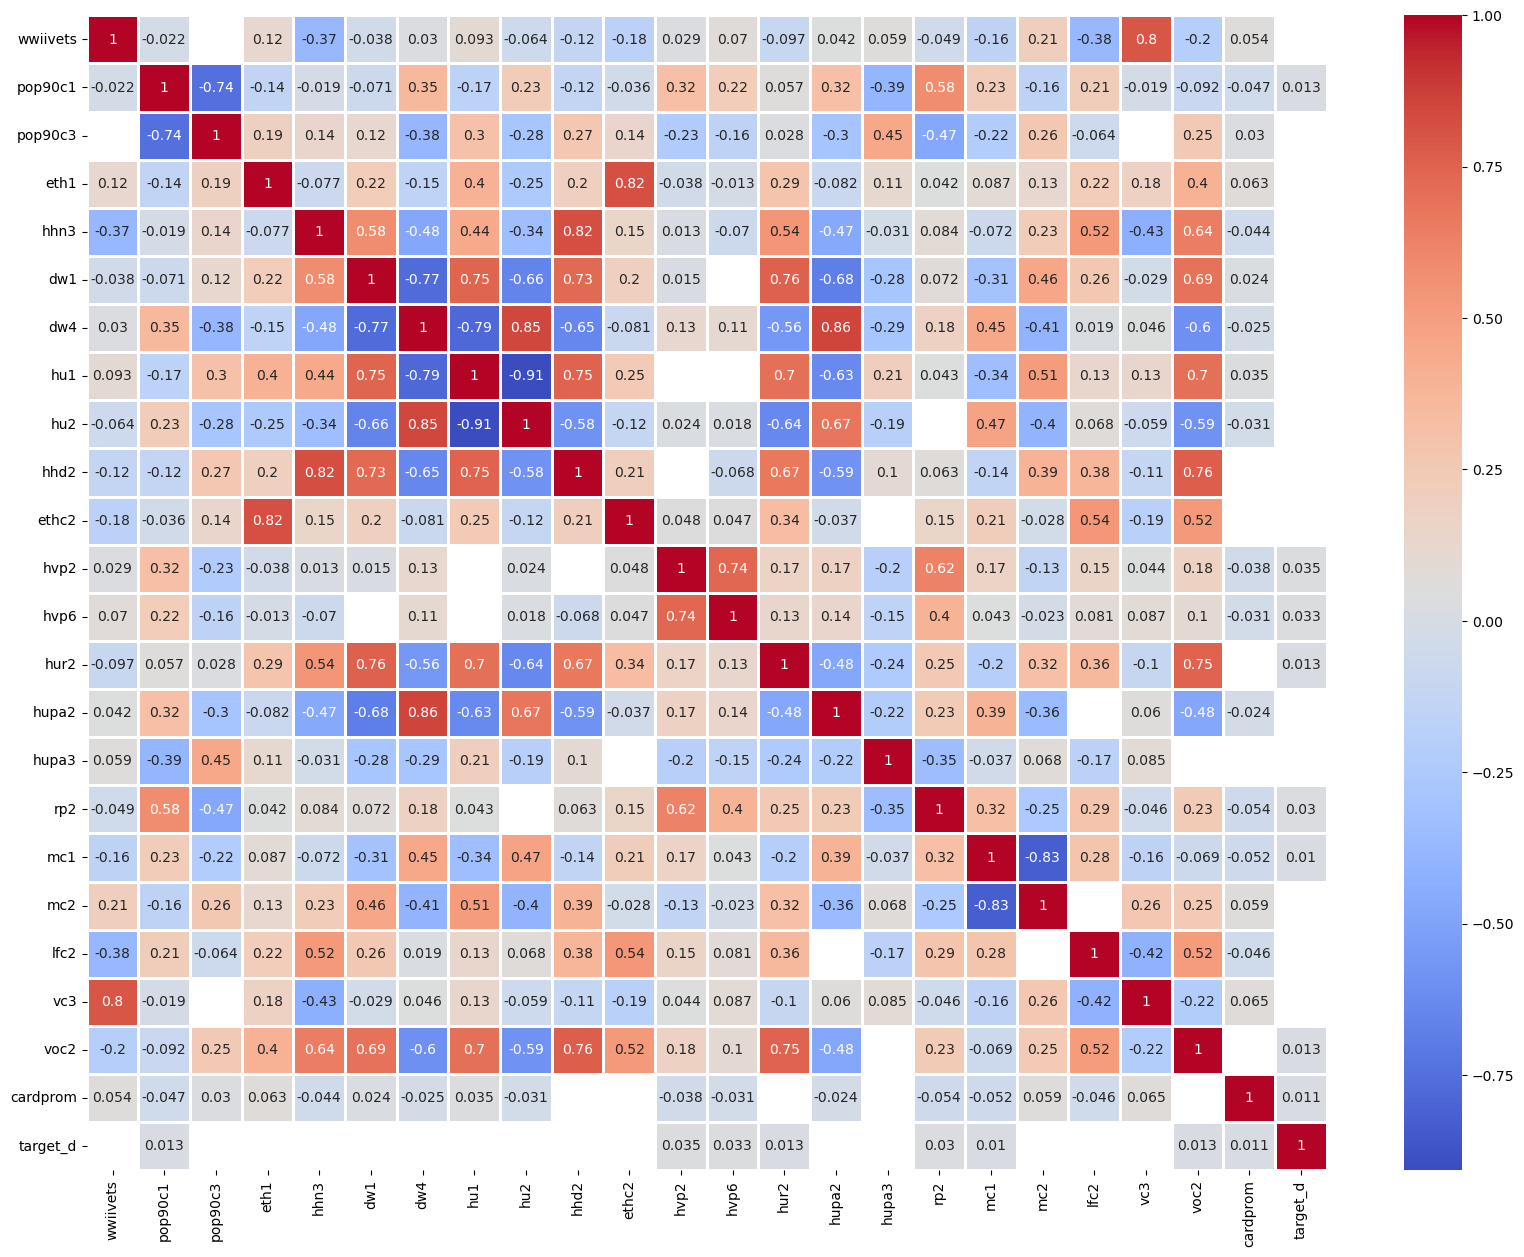

In [376]:
corr_matrix_rfe_num = num_target_d.corr(method= 'pearson')
fig, ax = plt.subplots(figsize = (20,15))
ax = sns.heatmap(corr_matrix_rfe_num, annot= True, cmap = sns.color_palette("coolwarm", as_cmap = True), linewidth = 1, mask = (np.abs(corr_matrix_rfe_num) <= 0.01))  #not dropping to many columns for my model
plt.show()

Multicolinearity drop according to the heatmap

In [373]:
multi_col_to_drop = list(['dw6', 'hvp1', 'hv2', 'rp1', 'lfc4', 'hupa6', 'pop90c2' ])

In [374]:
num_target_d = num_target_d.drop(multi_col_to_drop, axis =1)
num_target_d

,wwiivets,pop90c1,pop90c3,eth1,hhn3,dw1,dw4,hu1,hu2,hhd2,ethc2,hvp2,hvp6,hur2,hupa2,hupa3,rp2,mc1,mc2,lfc2,vc3,voc2,cardprom,target_d
0,18,0,65,92,49,97,2,86,14,80,50,7,0,61,0,0,5,46,54,64,18,77,27,0.0
1,11,99,0,67,75,99,0,96,4,94,44,98,94,83,0,0,91,56,44,83,11,92,12,0.0
2,33,0,98,96,44,69,6,78,22,76,60,1,0,36,2,24,2,38,62,73,32,65,26,0.0
3,31,0,92,61,50,85,4,48,52,73,36,25,10,42,0,9,8,46,54,81,31,43,27,0.0
4,53,99,0,2,57,99,0,90,10,82,1,1,0,45,0,0,58,20,80,73,53,45,43,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95407,11,99,0,78,48,54,32,56,44,72,55,10,0,40,8,13,84,63,37,89,11,60,6,0.0
95408,19,96,4,91,70,89,1,88,12,89,58,71,5,77,0,10,26,83,17,88,19,84,4,0.0
95409,20,99,0,82,44,96,2,66,34,64,49,0,0,45,0,0,34,43,57,70,20,42,14,0.0
95410,20,99,0,92,65,99,0,88,12,85,56,96,9,90,0,0,88,43,57,88,20,85,36,18.0


In [378]:
data_num_donations = num_target_d[num_target_d['target_d'] != 0]

In [379]:
encoded_categorical

array([[0., 0., 1., ..., 0., 1., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [408]:
# variance on categorical
var_threshold_cat = 0.035
sel_cat = VarianceThreshold(threshold = (var_threshold_cat))

sel_cat = sel_cat.fit(encoded_categorical)
temp_cat = sel_cat.transform(encoded_categorical)
temp_cat = pd.DataFrame(temp_cat)
print(encoded_categorical.shape)
print(temp_cat.shape)

(95412, 319)
(95412, 101)


In [409]:
# list of categorical to drop
sel_cat.variances_ > var_threshold_cat  
sel_cat.get_support()
var_list_cat = list(sel_cat.get_support())
list(zip(categorical.columns, var_list_cat))
list_to_drop_cat = [col[0] for col in zip(categorical.columns, var_list_cat) if col[1] == False] 

In [410]:
cat = categorical.drop(list_to_drop_cat, axis = 1)
cat

,state,homeownr,datasrce,rfa_2a,geocode2,domain_a,odatew_yr
0,IL,H,3,E,C,T,89
1,CA,H,3,G,A,S,94
2,NC,U,3,E,C,R,90
3,CA,U,3,E,C,R,87
4,FL,H,3,F,A,S,86
...,...,...,...,...,...,...,...
95407,other,H,3,G,C,C,96
95408,TX,H,3,F,A,C,96
95409,MI,H,3,E,B,C,95
95410,CA,H,2,F,A,C,86


In [420]:
# encoding the remaining categoricals
encoder_1 = OneHotEncoder(drop='first').fit(cat)
encoded_cat = encoder_1.transform(cat).toarray()
encoded_cat_df = pd.DataFrame(encoded_cat, columns = encoder_1.get_feature_names_out())
encoded_cat_df


,state_FL,state_GA,state_IL,state_IN,state_MI,state_MO,state_NC,state_TX,state_WA,state_WI,state_other,homeownr_U,datasrce_2,datasrce_3,rfa_2a_E,rfa_2a_F,rfa_2a_G,geocode2_B,geocode2_C,geocode2_D,domain_a_R,domain_a_S,domain_a_T,domain_a_U,odatew_yr_84,odatew_yr_85,odatew_yr_86,odatew_yr_87,odatew_yr_88,odatew_yr_89,odatew_yr_90,odatew_yr_91,odatew_yr_92,odatew_yr_93,odatew_yr_94,odatew_yr_95,odatew_yr_96,odatew_yr_97
0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95407,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
95408,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
95409,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
95410,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [421]:
cat_target_d = pd.concat([cat, y_d], axis = 1)
cat_target_d

,state,homeownr,datasrce,rfa_2a,geocode2,domain_a,odatew_yr,target_d
0,IL,H,3,E,C,T,89,0.0
1,CA,H,3,G,A,S,94,0.0
2,NC,U,3,E,C,R,90,0.0
3,CA,U,3,E,C,R,87,0.0
4,FL,H,3,F,A,S,86,0.0
...,...,...,...,...,...,...,...,...
95407,other,H,3,G,C,C,96,0.0
95408,TX,H,3,F,A,C,96,0.0
95409,MI,H,3,E,B,C,95,0.0
95410,CA,H,2,F,A,C,86,18.0


In [422]:
cat_encoded_target_d = pd.concat([encoded_cat_df,y_d], axis= 1)
cat_encoded_target_d

,state_FL,state_GA,state_IL,state_IN,state_MI,state_MO,state_NC,state_TX,state_WA,state_WI,state_other,homeownr_U,datasrce_2,datasrce_3,rfa_2a_E,rfa_2a_F,rfa_2a_G,geocode2_B,geocode2_C,geocode2_D,domain_a_R,domain_a_S,domain_a_T,domain_a_U,odatew_yr_84,odatew_yr_85,odatew_yr_86,odatew_yr_87,odatew_yr_88,odatew_yr_89,odatew_yr_90,odatew_yr_91,odatew_yr_92,odatew_yr_93,odatew_yr_94,odatew_yr_95,odatew_yr_96,odatew_yr_97,target_d
0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95407,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
95408,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
95409,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
95410,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,18.0


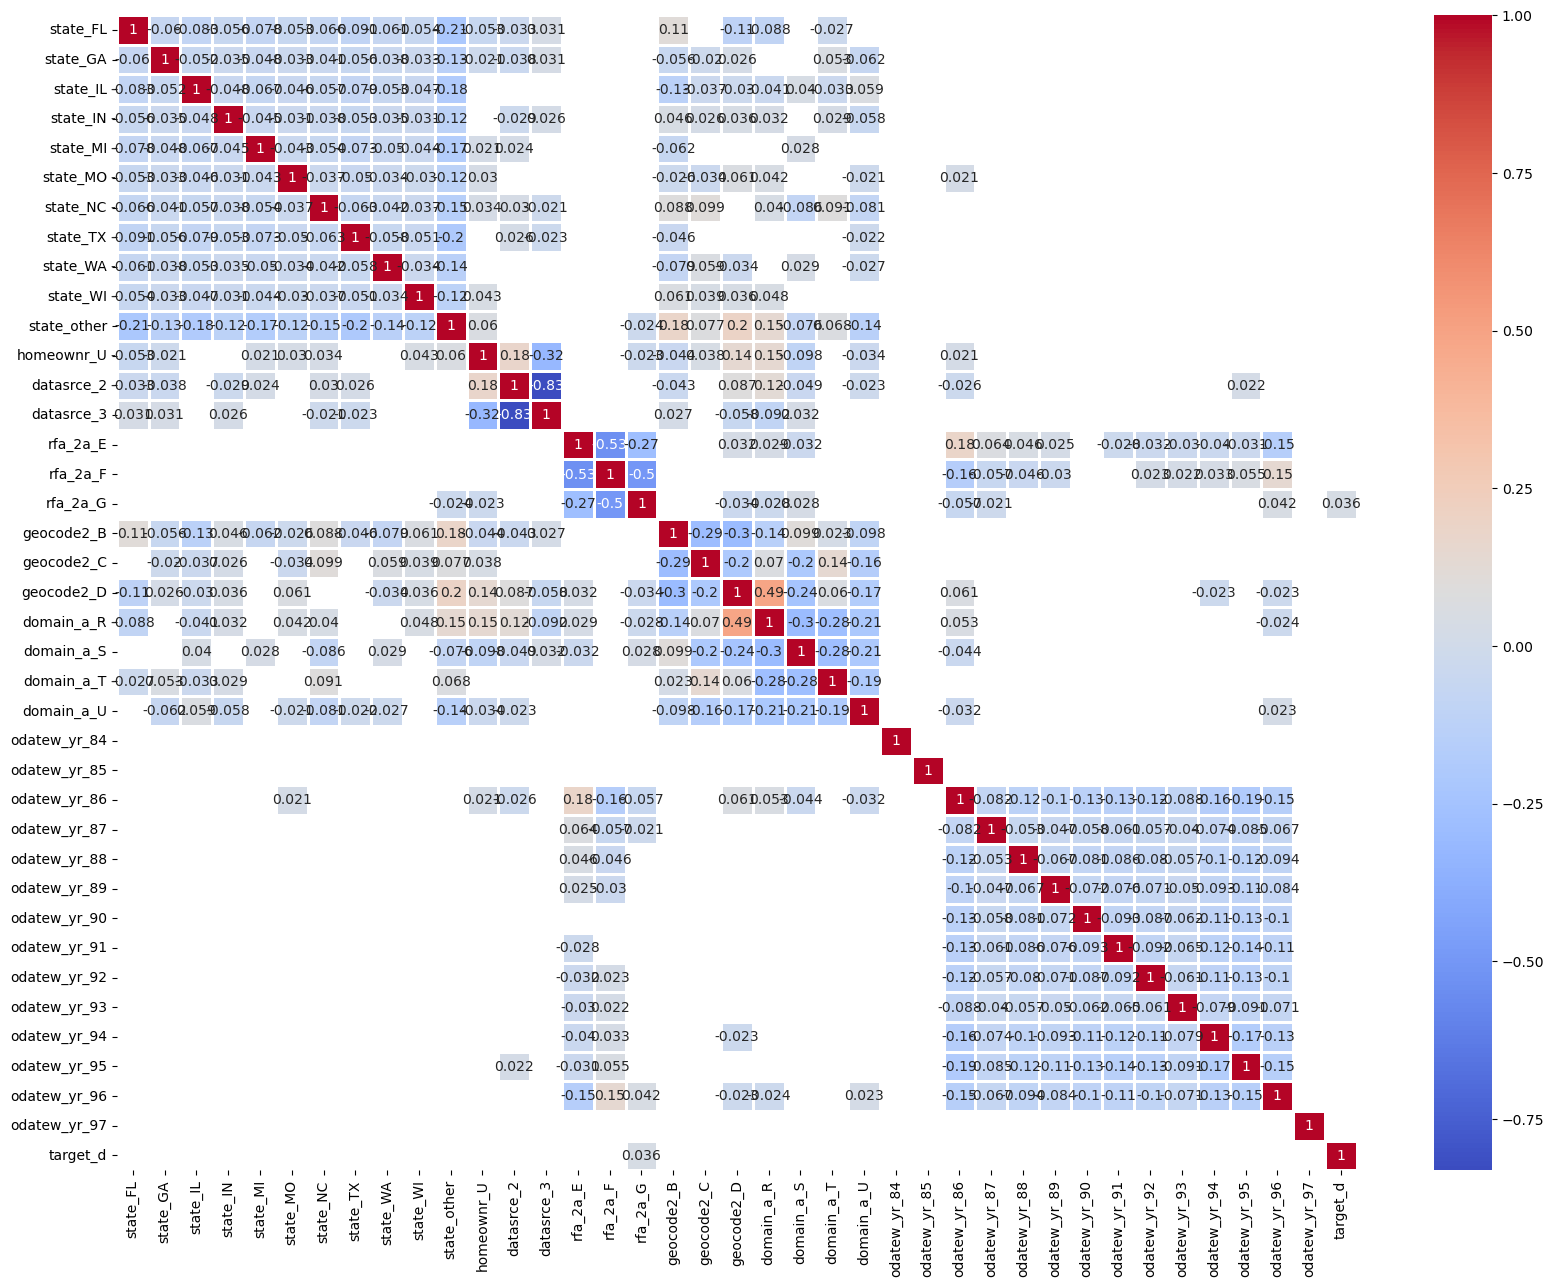

In [423]:
# heatmap (but very unreadable, so NOT helpful AT ALL !!!)
corr_matrix_cat = cat_encoded_target_d.corr(method= 'pearson')
fig, ax = plt.subplots(figsize = (20,15))
ax = sns.heatmap(corr_matrix_cat, annot= True, cmap = sns.color_palette("coolwarm", as_cmap = True), linewidth = 1, mask = (np.abs(corr_matrix_cat) <= 0.02))  #not dropping to many columns for my model
plt.show()

In [411]:
# # rfe on categoricals
# rfe_cat = RFE(lm, n_features_to_select = 10, verbose = False) # selecting only 10 features (we assume the categoricals will have less importance in our models)
# rfe_cat.fit(encoded_cat, y_d)

In [412]:
# df_rfe_cat = pd.DataFrame(data = rfe_cat.ranking_, columns=['Rank'])
# df_rfe_cat['Column_name'] = pd.DataFrame(cat).columns

# df_rfe_cat['Rank'].value_counts()
# print(len(df_rfe_cat[df_rfe_cat['Rank'] == 1]))
# cols_rfe_cat = df_rfe_cat.sort_values(by = ['Rank'], ascending = False).head(10)['Column_name']
# cols_rfe_cat_list = list(cols_rfe_cat)
# print(len(cols_rfe_cat_list))
# col_to_drop_rfe_c = df_rfe_cat[df_rfe_cat['Rank'] != 1]
# col_to_drop_rfe_c_list1 = col_to_drop_rfe_c['Column_name'].values.tolist()

# print('we are going to drop :', len(col_to_drop_rfe_c_list1), 'columns')
# print('\n')
# print('here is the list of the columns to drop :', col_to_drop_rfe_c_list1)

In [ ]:
# kbest_cat = SelectKBest(chi2, k = 10).fit_transform(encoded_cat, y_d)
# selected_cat = pd.DataFrame(kbest_cat)


slicing the initial data according to our features selection

In [432]:
Donations = pd.concat([num, cat, y_b, y_d], axis = 1)
Donations

,wwiivets,pop90c1,pop90c2,pop90c3,eth1,hhn3,dw1,dw4,dw6,hv2,hu1,hu2,hhd2,ethc2,hvp1,hvp2,hvp6,hur2,hupa2,hupa3,hupa6,rp1,rp2,mc1,mc2,lfc2,lfc4,vc3,voc2,cardprom,state,homeownr,datasrce,rfa_2a,geocode2,domain_a,odatew_yr,target_b,target_d
0,18,0,35,65,92,49,97,2,0,635,86,14,80,50,2,7,0,61,0,0,0,2,5,46,54,64,64,18,77,27,IL,H,3,E,C,T,89,0,0.0
1,11,99,0,0,67,75,99,0,0,5218,96,4,94,44,97,98,94,83,0,0,0,91,91,56,44,83,81,11,92,12,CA,H,3,G,A,S,94,0,0.0
2,33,0,2,98,96,44,69,6,3,546,78,22,76,60,0,1,0,36,2,24,3,0,2,38,62,73,70,32,65,26,NC,U,3,E,C,R,90,0,0.0
3,31,0,8,92,61,50,85,4,0,1263,48,52,73,36,10,25,10,42,0,9,0,1,8,46,54,81,68,31,43,27,CA,U,3,E,C,R,87,0,0.0
4,53,99,0,0,2,57,99,0,0,594,90,10,82,1,0,1,0,45,0,0,0,25,58,20,80,73,65,53,45,43,FL,H,3,F,A,S,86,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95407,11,99,0,0,78,48,54,32,14,1025,56,44,72,55,2,10,0,40,8,13,12,69,84,63,37,89,83,11,60,6,other,H,3,G,C,C,96,0,0.0
95408,19,96,0,4,91,70,89,1,0,1723,88,12,89,58,18,71,5,77,0,10,0,16,26,83,17,88,87,19,84,4,TX,H,3,F,A,C,96,0,0.0
95409,20,99,0,0,82,44,96,2,0,377,66,34,64,49,0,0,0,45,0,0,0,3,34,43,57,70,70,20,42,14,MI,H,3,E,B,C,95,0,0.0
95410,20,99,0,0,92,65,99,0,0,2459,88,12,85,56,89,96,9,90,0,0,0,88,88,43,57,88,85,20,85,36,CA,H,2,F,A,C,86,1,18.0


the donnors

In [433]:
Donations_target_d = Donations[Donations['target_b'] == 1]
Donations_target_d_refined = Donations_target_d.drop(['target_b'],axis = 1)
Donations_target_d_refined

,wwiivets,pop90c1,pop90c2,pop90c3,eth1,hhn3,dw1,dw4,dw6,hv2,hu1,hu2,hhd2,ethc2,hvp1,hvp2,hvp6,hur2,hupa2,hupa3,hupa6,rp1,rp2,mc1,mc2,lfc2,lfc4,vc3,voc2,cardprom,state,homeownr,datasrce,rfa_2a,geocode2,domain_a,odatew_yr,target_d
20,27,99,0,0,97,47,89,10,8,960,88,12,72,58,0,4,0,64,8,0,7,95,96,61,39,82,80,27,69,26,other,H,3,D,A,S,87,4.0
30,16,99,0,0,94,71,99,0,0,1166,97,3,92,60,4,15,2,91,0,0,0,78,83,74,26,98,97,16,91,10,TX,H,3,D,A,T,90,7.0
45,39,89,0,11,99,35,69,28,4,1399,96,4,76,62,15,33,2,70,0,0,0,39,57,61,39,79,78,39,67,31,other,H,3,D,C,C,86,5.0
78,54,99,0,0,97,27,78,20,8,5471,63,37,59,63,99,99,95,51,5,0,6,92,94,55,45,78,76,45,67,22,CA,H,2,F,A,S,90,13.0
93,8,99,0,0,7,72,98,0,0,698,89,11,90,3,0,0,0,84,0,0,0,69,84,39,61,91,78,8,76,19,GA,H,3,E,A,S,92,10.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95298,37,0,99,1,94,30,79,20,8,752,57,43,61,45,2,5,1,18,4,1,8,13,38,60,40,54,50,37,42,33,CA,H,3,F,A,T,86,20.0
95309,24,99,0,0,90,46,70,22,19,1692,72,28,75,57,23,68,0,49,8,7,13,58,80,86,14,86,82,24,71,13,CA,H,3,F,B,S,94,15.0
95398,26,99,0,0,85,41,69,30,29,975,75,25,70,57,1,2,0,58,24,0,22,30,94,32,68,80,78,26,72,29,WI,H,3,G,B,S,86,3.0
95403,20,0,1,99,99,51,81,10,7,606,79,21,77,57,0,0,0,65,4,8,7,0,2,38,62,78,75,21,75,22,other,H,2,F,D,R,90,10.0


In [436]:
# the mean amount of donations
Donations_target_d_refined['target_d'].mean()

15.624344414619037

Splitting the data

In [485]:
X_donations = Donations_target_d_refined.drop(['target_d'], axis = 1)
y_donations = Donations_target_d_refined['target_d']

X_train_don, X_test_don, y_train_don, y_test_don = train_test_split( X_donations, y_donations, test_size = 0.2, random_state = 88)

In [442]:
X_train_don_cat = X_train_don.select_dtypes(include = object)
X_train_don_num =X_train_don.select_dtypes(include = np.number)
X_test_don_cat = X_test_don.select_dtypes(include = object)
X_test_don_num =X_test_don.select_dtypes(include = np.number)

encoding categorical

In [443]:
encoder_2 = OneHotEncoder(drop='first').fit(X_train_don_cat)

X_train_don_cat_encoded = encoder_2.transform(X_train_don_cat).toarray()
X_train_don_cat_encoded_df = pd.DataFrame(X_train_don_cat_encoded, columns = encoder_2.get_feature_names_out())

X_test_don_cat_encoded = encoder_2.transform(X_test_don_cat).toarray()
X_test_don_cat_encoded_df = pd.DataFrame(X_test_don_cat_encoded, columns = encoder_2.get_feature_names_out())

scalling numerical

In [445]:
transformer_2 = MinMaxScaler().fit(X_train_don_num)
X_train_don_num_scale = transformer_2.transform(X_train_don_num)
X_train_don_num_scale_df = pd.DataFrame(X_train_don_num_scale, index = X_train_don_num.index, columns = X_train_don_num.columns)

X_test_don_num_scale = transformer_2.transform(X_test_don_num)
X_test_don_num_scale_df = pd.DataFrame(X_test_don_num_scale, index = X_test_don_num.index, columns = X_test_don_num.columns)

concatenate the arrays

In [484]:
X_train_don_norm = np.concatenate([X_train_don_num_scale, X_train_don_cat_encoded], axis =1)
X_test_don_norm = np.concatenate([X_test_don_num_scale, X_test_don_cat_encoded], axis = 1)
y_donations_array = np.array(Donations_target_d_refined['target_d'])

## Regression time !

In [456]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import SGDRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn import linear_model
from sklearn.metrics import r2_score

'n_estimators': 800, 'min_samples_split': 5, 'min_samples_leaf': 10, 'max_features': 'sqrt', 'max_depth': 6, 'bootstrap': False

In [457]:
def make_models_and_get_scores(xtrain, xtest, ytrain, ytest):
    model = []
    train = []
    test = []
    Scores_results = pd.DataFrame()


    KNN = KNeighborsRegressor(n_neighbors = 5,
                             weights= 'uniform',
                              p = 1
                              )
    KNN.fit(xtrain, ytrain)
    model.append("K-Neighbors")
    KNN_R2_score_train = KNN.score(xtrain, ytrain)
    train.append(KNN_R2_score_train)
    KNN_R2_score_test = KNN.score(xtest, ytest)
    test.append(KNN_R2_score_test)
   

    linreg = linear_model.LinearRegression().fit(xtrain,ytrain)
    model.append("Linear Regression")
    linreg_predictions_train = linreg.predict(xtrain)
    linreg_R2_score_train = r2_score(ytrain, linreg_predictions_train)
    train.append(linreg_R2_score_train)
    linreg_predictions_test = linreg.predict(xtest)
    linreg_R2_score_test = r2_score(ytest, linreg_predictions_test)
    test.append(linreg_R2_score_test)


    regr = MLPRegressor(random_state = 1,
                         max_iter = 500
                         ).fit(xtrain, ytrain)
    model.append("MLP Regressor")
    mlp_score_train = regr.score(xtrain, ytrain)
    train.append(mlp_score_train)
    mlp_score_test = regr.score(xtest, ytest)
    test.append(mlp_score_test)

    rfregressor = RandomForestRegressor(max_depth = 6,  
                             min_samples_split = 5,  
                             min_samples_leaf = 10,
                             n_estimators = 800,
                             max_features = 'sqrt', 
                             bootstrap= False,
                             random_state = 88)
    rfregressor.fit(xtrain,ytrain)
    model.append("Random-Forest")
    rf_score_train = rfregressor.score(xtrain,ytrain)
    train.append(rf_score_train)
    rf_score_test = rfregressor.score(xtest,ytest)
    test.append(rf_score_test)

    # dregr = DecisionTreeRegressor(max_depth = 10)
    # dregr.fit(xtrain, ytrain)
    # model.append('Decision tree')
    # dec_tree_train = dregr.score(xtrain, ytrain)
    # train.append(dec_tree_train)
    # dec_tree_test = dregr.score(xtest, ytest)
    # test.append(dec_tree_test)


   
    Scores_results["model"] = model
    Scores_results["r2_train"] = train
    Scores_results["r2_test"] = test

    return Scores_results

In [458]:
scores_regressors = make_models_and_get_scores(X_train_don_norm, X_test_don_norm, y_train_don, y_test_don)
scores_regressors

,model,r2_train,r2_test
0,K-Neighbors,0.466624,0.255234
1,Linear Regression,0.388534,0.319741
2,MLP Regressor,0.576263,0.302082
3,Random-Forest,0.393164,0.255072


A pipepline with a cross validation 10 fold

In [466]:
model_pipeline = [KNeighborsRegressor(),
                 LinearRegression(), 
                 MLPRegressor(random_state = 88,
                              max_iter = 900),
                 
                 SGDRegressor(max_iter = 2000,
                             verbose = 0,
                             warm_start= True,
                             random_state = 88), 
                 RandomForestRegressor(max_depth = 6,  
                             min_samples_split = 5,  
                             min_samples_leaf = 10,
                             n_estimators = 800,
                             max_features = 'sqrt', 
                             bootstrap= False,
                             random_state = 88)]
model_names = ['KNN', 'Linear regression', 'Perceptron', 'SGD', 'Random forest']
scores_pipe = {}
for model, model_name in zip(model_pipeline, model_names):
    mean_score = np.mean(cross_val_score(model, X_train_don_norm, y_train_don, cv = 10))
    scores_pipe[model_name] = mean_score
print(scores_pipe)

{'KNN': 0.2161557689229209, 'Linear regression': 0.35813432451363425, 'Perceptron': 0.22916938075567078, 'SGD': 0.3832562553451098, 'Random forest': 0.2980475215635957}


tunning the random forest regressor

In [482]:
# grid_search = GridSearchCV(estimator = RandomForestRegressor(), param_grid = random_grid, cv = 5)
# grid_search.fit(X_train_don_norm, (np.array(y_train_don)))

In [ ]:
# print(' my best hyperparameters are :' , grid_search.best_params_)
# print ('my average score is : ', grid_search.best_score_)

# Getting the predicted amount for donations

    - getting the data with the predicted positive donors by using the classifier

    - from this data, we wil use the regressor to predict the amount they will give

    - from those amount we wil calculate the mean value and the Total revenue it will generate for the organisation

In [492]:
Donations_num = Donations.select_dtypes(np.number)
Donations_cat = Donations.select_dtypes(object)

In [493]:
# scalling the data
encoder_3 = OneHotEncoder(drop='first').fit(Donations_cat)
encoded_Donations_cat = encoder_3.transform(Donations_cat).toarray()
encoded_Donations_cat_df = pd.DataFrame(encoded_Donations_cat, columns = encoder_3.get_feature_names_out())

In [497]:
scaler_min_3 = MinMaxScaler()
Donations_num_scaled = scaler_min_3.fit_transform(Donations_num)
Donations_num_scaled_df = pd.DataFrame(Donations_num_scaled, columns = Donations_num.columns)

In [501]:
# gerging the data
pred_for_donnation = pd.concat([encoded_Donations_cat_df, Donations_num_scaled_df], axis =1)

In [502]:
Donations['prediction_for_donation'] = clf_hyper_tuned.predict(pred_for_donnation)

ValueError: X has 56 features, but RandomForestClassifier is expecting 19 features as input.

In [460]:
# raw_data_sclice_refined_v2 = pd.concat([raw_data_sclice_refined, y_d], axis = 1)  # append the amount to the people who donate
# raw_donations = raw_data_sclice_refined_v2[raw_data_sclice_refined_v2['target_b'] == 1]
# raw_donations

In [461]:
# donations = raw_donations.drop(['target_b'], axis =1) #removing the target_b
# donations

In [462]:
# expectation = donations.drop(['target_d'], axis = 1)
# expectation

In [463]:
# donations['pred_donation'] = clf_tuned.predict(expectation)
# donations_expected = donations[donations['pred_donation'] == 1]
# donations_expected

In [464]:
# donations_expected_refined = donations_expected.drop(['pred_donation'], axis = 1)
# donations_expected_refined

In [465]:
scores = make_models_and_get_scores(X_train_don_norm, X_test_don_norm, y_train_don, y_test_don)
scores

,model,r2_train,r2_test
0,K-Neighbors,0.466624,0.255234
1,Linear Regression,0.388534,0.319741
2,MLP Regressor,0.576263,0.302082
3,Random-Forest,0.393164,0.255072
